#🌋HYPERPARAMETER



In [74]:
### HYPERPARAMETER ###

from google.colab import drive, userdata
drive.mount('/content/drive', force_remount=True)

PROJECT_ROOT = userdata.get("gdrive_seo_root")
PROJECT_ROOT_ESC_STR = PROJECT_ROOT.replace('Colab Notebooks', 'Colab\ Notebooks')

SRC_PATH, DATA_PATH = PROJECT_ROOT + "/src", PROJECT_ROOT + "/data"
FAISS_PATH = DATA_PATH + '/faiss_db'
KEYWORD_PATH = DATA_PATH + '/keywords'
PROMPT_PATH = DATA_PATH + '/prompts'

START_URL = "https://www.rue-zahnspange.de/"
EXCLUDED_WEBSITES = ["impressum", "datenschutz", "agb"]


Mounted at /content/drive


# 🏁 Install requirements + dependencies

In [2]:
%run '/content/drive/MyDrive/Colab Notebooks/SEO/notebooks/Installation.ipynb'

In [3]:
%run '/content/drive/MyDrive/Colab Notebooks/SEO/src/dependencies.py'

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 📔 READ_ME und TO_DO

In [35]:
%%writefile '/content/drive/MyDrive/Colab Notebooks/SEO/READ_ME.md'
# 🚀 SEO Automation Pipeline mit OpenAI & Retrieval (RAG)

Dieses Projekt bietet eine **komplette End-to-End-Pipeline für die SEO-Optimierung von Websites**, inklusive **Web-Scraping, SEO-Analyse, KI-gestützter Text-Optimierung und Qualitätskontrolle**.

Kern des Projekts sind **automatisierte Abläufe**, die von der **Datengewinnung bis zur SEO-optimierten Textgenerierung** reichen.
Mithilfe von **OpenAI (ChatGPT)** und einer **Retrieval Augmented Generation (RAG)-Architektur** wird sichergestellt, dass die finalen Texte nicht nur **SEO-freundlich**, sondern auch **grammatikalisch korrekt und hochwertig** sind.

## 📚 Inhaltsverzeichnis

- [Features](#features)
- [Projektstruktur](#projektstruktur)
- [Ablauf & Module](#ablauf--module)
- [Technologien](#technologien)
- [Installation](#installation)
- [Nutzung](#nutzung)
- [Ziele](#ziele)
- [Roadmap](#roadmap)

## ✅ Features

- 🌐 **Automatisiertes Web Scraping** (inkl. Filter für relevante Inhalte)
- ✍️ **Generierung von SEO-optimierten Texten** mithilfe der OpenAI API
- 🧠 **RAG-gestützte Fehlererkennung & Textkorrektur** mit Vektordatenbank (FAISS)
- 📊 **Analyse der Optimierungsergebnisse** (Statistiken, Ähnlichkeiten, Visualisierungen)
- 📈 **Keyword-Analyse und Keyword-Optimierung**
- 📦 Ausgabe in **HTML und PDF** für Kunden
- 📊 Umfangreiche **Datenvisualisierungen** (Wordclouds, Cosine Similarity, Keyword-Verteilung)

## 🗂️ Projektstruktur

```
SEO-Project/
├── data/                # Prompts, Fehler-Korrektur-Daten, weitere JSON Dateien
├── notebooks/           # Colab/Notebooks zum Starten und Entwickeln
├── src/                # Source Code (Python-Klassen und Module)
│   ├── webscraper.py    # Webscraping und Text-Extraktion
│   ├── llm_processor.py # Anbindung an OpenAI API, Keyword Extraktion
│   ├── chatbot.py       # Zentrale Chatbot-Klasse zur Kommunikation mit GPT
│   ├── seoanalyzer.py   # Analyse und Auswertung der Texte
│   ├── github.py        # Automatischer Upload ins GitHub Repo
│   ├── rag_checker.py   # RAG-Modul für Fehlerkorrektur via FAISS
│   ├── utils.py         # Hilfsmodule (z.B. für Prompt-Management)
│   └── embedding_demo.py# 3D Embedding- und Cosine Similarity Visualisierungen
└── requirements.txt    # Python-Abhängigkeiten
```

## ⚙️ Ablauf & Module

### 1. **Web Scraping**
- **src/webscraper.py**: Holt Inhalte von Webseiten, filtert irrelevante Seiten (z.B. Impressum, AGB).

### 2. **SEO-Optimierung mit OpenAI**
- **src/llm_processor.py**:
  - Extrahiert Keywords aus den Inhalten.
  - Optimiert die Texte für SEO mit gezielten Prompts.

### 3. **Fehlerkontrolle mit RAG**
- **src/rag_checker.py**: Erstellt eine Vektordatenbank mit bekannten Fehlern und Korrekturen. Erkennt fehlerhafte Formulierungen via Cosine Similarity und optimiert mit ChatGPT.

### 4. **Analyse & Visualisierung**
- **src/seoanalyzer.py**: Verarbeitet und analysiert die Original- und optimierten Texte.

### 5. **GitHub Automation**
- **src/github.py**: Lädt finale Ergebnisse in ein GitHub-Repo hoch.

## 🧰 Technologien

| Technologie                  | Beschreibung                                       |
|-----------------------------|---------------------------------------------------|
| Python                      | Hauptsprache                                       |
| OpenAI API (ChatGPT, GPT-4)  | Generative KI für SEO-Texte                       |
| FAISS                      | Vektorsuche für RAG und Text-Fehler                |
| Pandas, NumPy               | Datenanalyse und Verarbeitung                      |
| Matplotlib, Seaborn         | Visualisierungen                                   |
| Sentence Transformers       | Embedding-Erstellung für Vektordatenbank          |
| BeautifulSoup, Requests     | Webscraping                                        |
| Google Colab                | Entwicklung und Ausführung                        |

## 🚀 Installation

```bash
pip install -r requirements.txt
python -m spacy download de_core_news_sm
pip install faiss-cpu sentence-transformers openai wordcloud matplotlib seaborn
```

## 💻 Nutzung

```python
scraper = WebsiteScraper(start_url="https://www.example.com")
scraper.scrape_website()

llm_processor = LLMProcessor(PROJECT_ROOT, scraper.get_scraped_data())
llm_processor.run_all()

seo_checker = SEORAGChecker(quality_checker, chatbot_system_prompt)
final_text = seo_checker.check_text(optimized_text)

seo_analyzer = SEOAnalyzer(seo_json, original_texts, keywords_final)
seo_analyzer.run_analysis()
```

## 🎯 Ziele

- ✅ Vollständige Automatisierung der SEO-Optimierung
- ✅ RAG für sprachliche Qualitätskontrolle
- ✅ Kundenfertige PDF/HTML-Reports

## 🚧 Roadmap

- [ ] Automatische SEO Scores (z.B. Google Ads API)
- [ ] Automatische Keyword-Erweiterung
- [ ] Mehrsprachigkeit (aktuell Deutsch)
- [ ] WordPress-Integration

## 🤝 Zusammenarbeit

Contributions und Ideen willkommen!
👉 Pull-Request oder Issue eröffnen.


Writing /content/drive/MyDrive/Colab Notebooks/SEO/READ_ME.md


In [54]:
%%writefile '/content/drive/MyDrive/Colab Notebooks/SEO/TO_DO.md'
# To-Do Liste: SEO Automation & KI-Projekt

Diese Liste fasst alle anstehenden Aufgaben im Projekt zusammen

---

## 1. **Allgemeine Projektorganisation**
- [ ] **Projektstruktur verbessern**: Ordner übersichtlich gestalten (z.B. `src/`, `data/`, `tests/`, `notebooks/`).
- [ ] **Dokumentation erweitern**: README und Wiki (bzw. GitHub Pages) zu jedem Modul anlegen.
- [ ] **Automatisierte Tests** (z.B. Pytest) für Kernfunktionen einrichten.

---

## 2. **Vector-Datenbank (FAISS) & Retrieval**
- [ ] **VectorDB-Klasse finalisieren**:
  - [ ] Kleinere Bugs beheben
  - [ ] Userfreundliche Methoden für neue Einträge
- [ ] **Einrichtung der DB** bei Projektstart (Neubau vs. Laden) vereinheitlichen
- [ ] **Konfigurierbare Ähnlichkeits-Schwelle** (z.B. `threshold=0.6`) besser dokumentieren
- [ ] **Dynamische Filter** für bestimmte Fehlerkategorien (z.B. Stil vs. Grammatik) überlegen

---

## 3. **SEO-Optimierungs-Pipeline (LangChain)**
- [ ] **LangChain-Workflow** debuggen und lauffähig machen
  - [ ] Placeholder & Prompt-Mapping für `format_messages(...)` beheben
  - [ ] `.role` vs. `_role`-Konflikt lösen (Debug-Statements anpassen)
- [ ] **Prompts in JSON-Dateien** verlagern (z.B. `/data/prompts/`) und sauber verlinken
- [ ] **Google Ads Keywords** Integration:
  - [ ] Nur LLM-Keyword-Extraktion aufrufen, wenn keine Google-Keywords vorliegen
- [ ] **Supervisor-Feedback** integrieren (optional) & QA-Schritte definieren

---

## 4. **SEOGrammarChecker & PromptManager**
- [ ] Klassenrefactoring:
  - [ ] **`VectorDB`** vs. **`PromptManager`** vs. **`SEOGrammarChecker`** sauber trennen
  - [ ] Möglichst wenig Code-Duplikate, mehr modulare Testbarkeit
- [ ] **Konfigurationsdatei** (z.B. YAML) für Pfade, wie `FAISS_PATH` & Promptordner
- [ ] **Erweiterbare Prompt-Templates**:
  - [ ] Z.B. `seo_optimization.json`, `grammar_check.json`, `supervisor.json`, etc.

---

## 5. **Abschluss & Integration**
- [ ] **Dokumentation** aller Pipelines & Klassen in der README (oder in separater Doku)
- [ ] **GitHub-Repo** publizieren (Entweder privat oder als Public Demo)
- [ ] **Optionale WordPress-Integration** in der Zukunft (Ideenspeicher)
  - [ ] Upload via REST API
  - [ ] Metadaten (Title, Slug, Tags etc.)

---

## 6. **Nächste Schritte**
- [ ] **Liste priorisieren**: Welche Punkte sind dringlich? Was kann warten?
- [ ] **Zeitplan erstellen**: Welche Teilaufgaben, bis wann?
- [ ] **Issues anlegen**: Jedes To-Do hier als eigenes Issue im GitHub-Repository, um Fortschritt zu tracken.


Overwriting /content/drive/MyDrive/Colab Notebooks/SEO/TO_DO.md


# ⛩ push to github

In [4]:
import github
importlib.reload(github)
from github import GitHubManager

# Starte den GitHub-Sync
git_manager = GitHubManager(
    userdata.get("github_pat"),
    userdata.get("github_email"),
    userdata.get("github_username"),
    userdata.get("github_repo_seo"),
    PROJECT_ROOT_ESC_STR
)

git_manager.clone_repo()  # Klonen des Repos
git_manager.sync_project()

📥 Klonen des GitHub-Repositories...
📂 Kopiere das Projekt ins Repository...
🔧 Git-Konfiguration wird gesetzt...
➕ Änderungen hinzufügen...
📌 Änderungen committen...
⬆️ Änderungen werden auf GitHub gepusht...
✅ Repository erfolgreich synchronisiert!


# 🕸 scrap

In [5]:
import webscraper
importlib.reload(webscraper)
from webscraper import WebsiteScraper

scraper = WebsiteScraper(start_url=START_URL, max_pages=20, excluded_keywords=EXCLUDED_WEBSITES)

original_texts = scraper.get_filtered_texts()

# 📺 google ads seo keywords

In [6]:
import excelimporter
importlib.reload(excelimporter)
from excelimporter import ExcelImporter

importer = ExcelImporter(
    project_folder=PROJECT_ROOT,
    header=2  # <-- 1 = "nehme die zweite Zeile als Spaltennamen"
)
keyword_df = importer.import_all()

excluded_seo_keywords = ['spange de', 'kfo zentrum essen']
keyword_df = keyword_df[(keyword_df['Avg. monthly searches'] > 10) &
 (~keyword_df['Keyword'].isin(excluded_seo_keywords))
 ].sort_values(by='Avg. monthly searches', ascending=False).reset_index(drop=True).copy()

google_ads_keywords = list(keyword_df['Keyword'])

✅ Geladen: /content/drive/MyDrive/Colab Notebooks/SEO/data/keywords/Keyword Stats 2025-03-09 at 12_41_38.xlsx


# 🔮webtext analysis + SEO

In [7]:
import llmprocessor
importlib.reload(llmprocessor)
from llmprocessor import LLMProcessor

llm_processor = LLMProcessor(PROJECT_ROOT, original_texts, google_ads_keywords=google_ads_keywords)

optimized_texts = llm_processor.run_all()

✅ Google Ads Keywords werden verwendet. LLM Keyword Extraktion wird übersprungen.
📍 Stadt für SEO-Kontext wird via LLM ermittelt...
🚀 Starte SEO-Optimierung mit LLM...

=== SEO-Optimierung für https://www.rue-zahnspange.de/ ===
Analyse  
Der aktuelle Text weist einige Stärken und Schwächen in Bezug auf die SEO-Optimierung auf. Die Verwendung von Keywords ist begrenzt und könnte gezielter erfolgen, um die Sichtbarkeit in Suchmaschinen zu erhöhen. Der Standort "Essen-Rüttenscheid" könnte prominenter in den Text integriert werden, um lokale Suchanfragen zu bedienen. Die Lesbarkeit ist insgesamt gut, jedoch könnten einige Abschnitte prägnanter gestaltet werden. Zudem fehlen Meta-Titel und Longtail-Keywords, die für die Auffindbarkeit und das Ranking wichtig sind. Häufig gestellte Fragen (FAQs) sind vorhanden, jedoch könnten diese ebenfalls durch gezielte Keywords optimiert werden. Insgesamt sollten die Begriffe wie „zahnärzte essen rüttenscheid“ und „kieferorthopädische zahnzusatzversicher

# 📁 Textprozessor

In [8]:
import textprocessor
importlib.reload(textprocessor)
from textprocessor import TextProcessor

# JSON mit den SEO-Abschnitten extrahieren
json_output = TextProcessor.extract_sections_to_json(list(optimized_texts.keys()), list(optimized_texts.values()))
seo_json = json.loads(json_output)

# texte bereinigen und hinzufügen
seo_json = TextProcessor.add_cleaned_text(seo_json, original_texts)

# Ergebnis anzeigen
print(json.dumps(seo_json, indent=4, ensure_ascii=False))


{
    "https://www.rue-zahnspange.de/": {
        "Analyse": "Der aktuelle Text weist einige Stärken und Schwächen in Bezug auf die SEO-Optimierung auf. Die Verwendung von Keywords ist begrenzt und könnte gezielter erfolgen, um die Sichtbarkeit in Suchmaschinen zu erhöhen. Der Standort Essen-Rüttenscheid könnte prominenter in den Text integriert werden, um lokale Suchanfragen zu bedienen. Die Lesbarkeit ist insgesamt gut, jedoch könnten einige Abschnitte prägnanter gestaltet werden. Zudem fehlen Meta-Titel und Longtail-Keywords, die für die Auffindbarkeit und das Ranking wichtig sind. Häufig gestellte Fragen FAQs sind vorhanden, jedoch könnten diese ebenfalls durch gezielte Keywords optimiert werden. Insgesamt sollten die Begriffe wie zahnärzte essen rüttenscheid und kieferorthopädische zahnzusatzversicherung zu einem natürlichen Teil des Textes werden.",
        "SEO": "Moderne Zahnspangen in Essen-Rüttenscheid für ein gesünderes Lächeln Entdecken Sie die Praxis RÜ Zahnspange in Essen

# 🔎 SEO Analyses + Statistics

In [9]:
llm_processor.get_keywords()['keywords_final']

['zahnärzte essen rüttenscheid',
 'zahn spange',
 'zahnzusatzversicherung bei kindern',
 'retainer kosten',
 'retainer zähne',
 'kfo essen',
 'zahnspangen englisch',
 'reinigung zahnschienen',
 'zahnschienen reinigung',
 'kieferorthopädische zahnzusatzversicherung',
 'invisalign erfahrung',
 'kiefer fehlstellung',
 'zahn retainer',
 'gerade zahne']


🔍 Wortfrequenz-Vergleich:
🔹 Wortfrequenz-Differenzen für Text 1:
in: 5
essen-rüttenscheid: 4
der: 2
sind: 2
ermöglichen: 1
kinder.: 1
einschließlich: 1
für: 1
gesunden: 1
eine: 1
🔹 Wortfrequenz-Differenzen für Text 2:
in: 7
sind: 6
sie: 6
essen-rüttenscheid: 4
und: 3
eine: 3
zahnfehlstellungen: 2
diese: 2
mehr: 2
der: 2
🔹 Wortfrequenz-Differenzen für Text 3:
mit: 3
in: 3
zahnspange: 3
essen-rüttenscheid: 3
zahnschienen: 2
oder: 2
die: 2
retainern: 1
zähnen: 1
zahnschienen,: 1
🔹 Wortfrequenz-Differenzen für Text 4:
in: 5
die: 4
und: 3
essen-rüttenscheid: 3
einschließlich: 2
zahnkorrektur: 2
zahnspangen,: 1
optimale: 1
retainer,: 1
diese: 1
🔹 Wortfrequenz-Differenzen für Text 5:
der: 6
für: 4
kieferorthopädie: 4
die: 4
zu: 3
um: 3
ihre: 3
zahnspangen,: 2
behandlungsmethoden: 2
bedürfnisse: 2

🔍 Berechnung der Similarities:
📊 Durchschnittliche Similarities (Original -> Keywords): [0.00740173 0.         0.00815013 0.01713173 0.09674165 0.01050673
 0.05668524 0.0201679  0.0201679  0.      

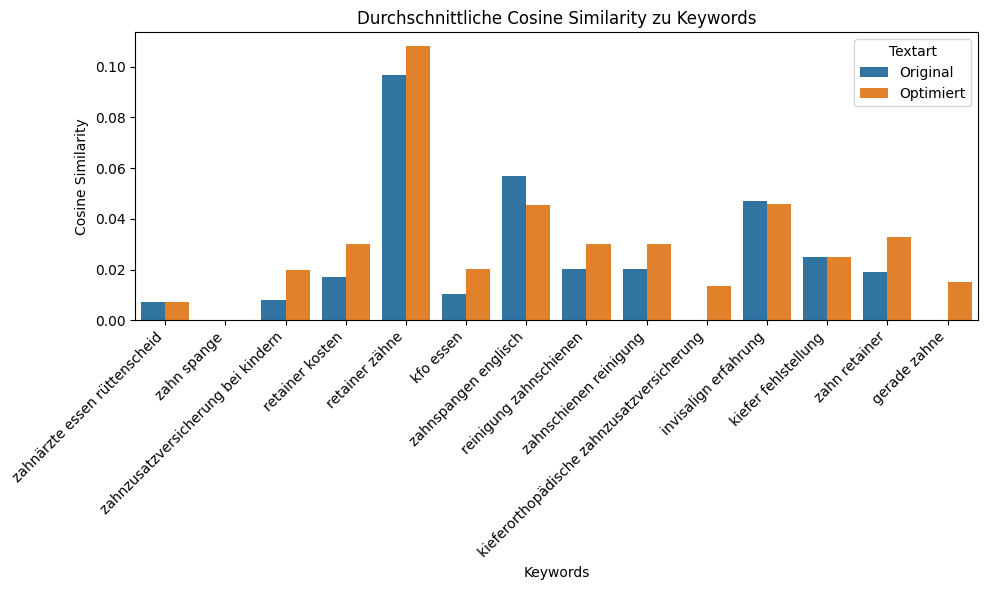


📊 Visualisierung der Keyword-Häufigkeiten:


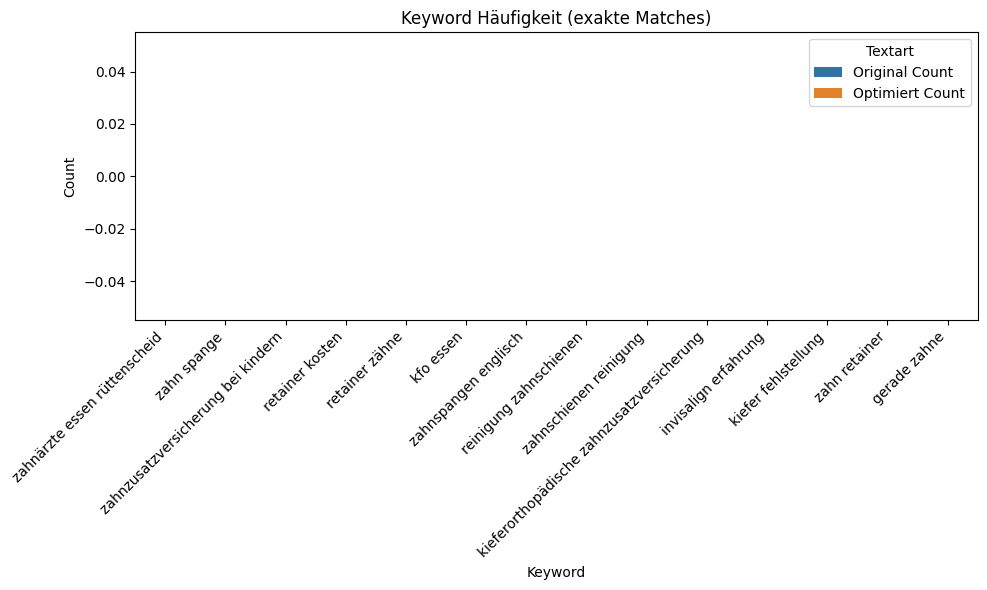


☁️ Wordcloud-Visualisierung:


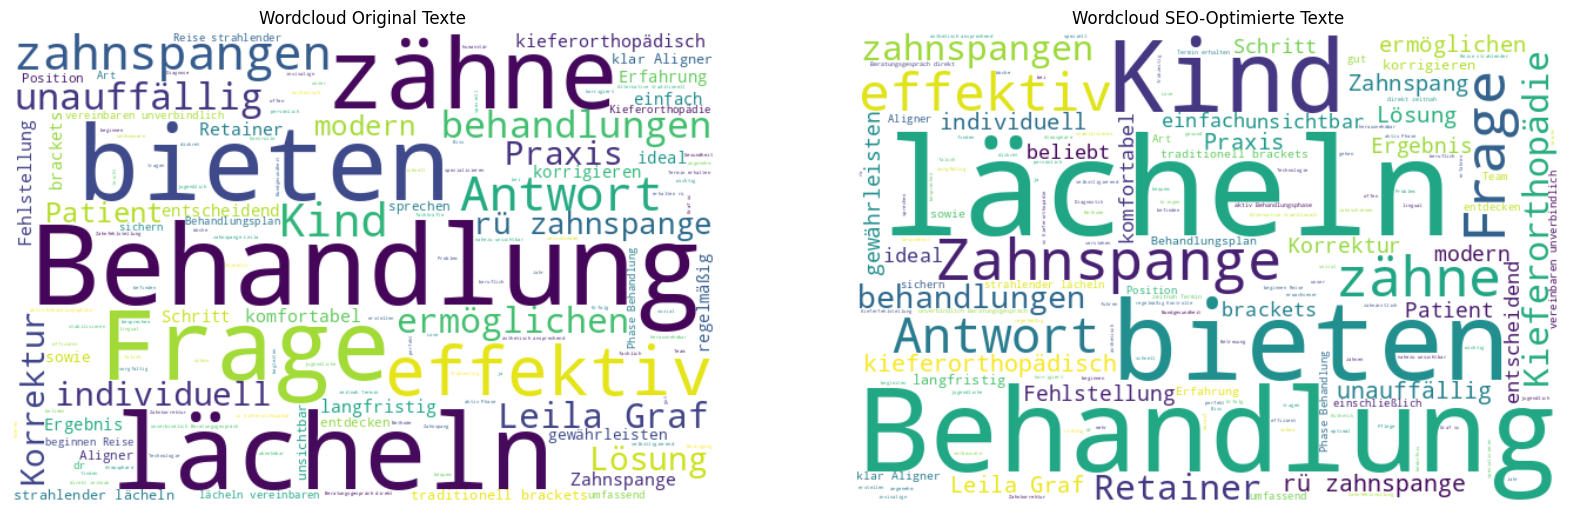

In [10]:
import seoanalyzer
importlib.reload(seoanalyzer)
from seoanalyzer import SEOAnalyzer

keywords_final = json.loads(llm_processor.get_keywords()['keywords_final']) if not google_ads_keywords else google_ads_keywords
seo_analyzer = SEOAnalyzer(seo_json, original_texts, keywords_final)
seo_analyzer.run_analysis()


# ▶◀ conversion rates, modelierungen

In [11]:
# Historische SEO-Daten
historical_data = {
    "Date": [
        "2023-01-01", "2023-02-01", "2023-03-01",
        "2023-04-01", "2023-05-01", "2023-06-01"
    ],
    "Organic_Sessions": [200, 220, 250, 400, 450, 480],
    "Conversion_Rate": [0.02, 0.021, 0.022, 0.028, 0.03, 0.031],
    "Average_Time_on_Page": [40, 42, 45, 60, 65, 70]
}


📊 Historische SEO-Trends


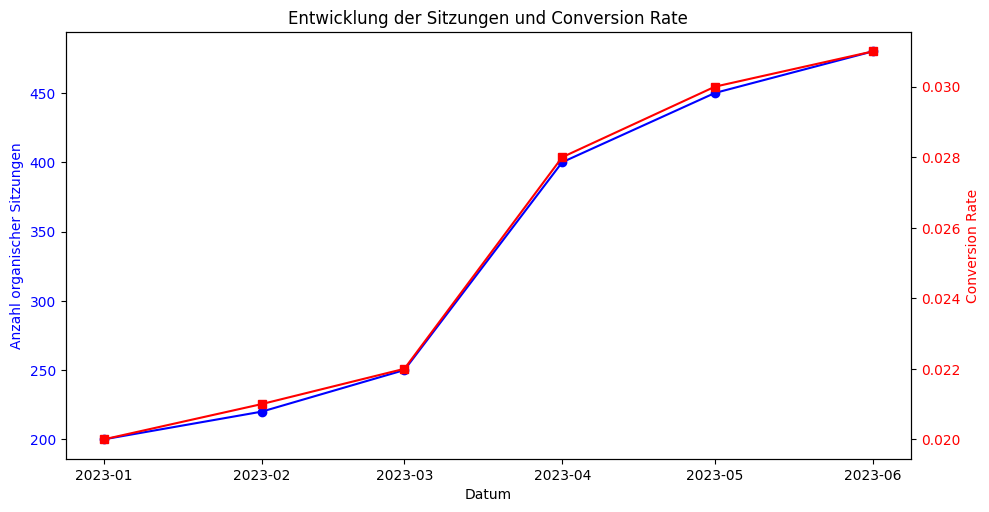

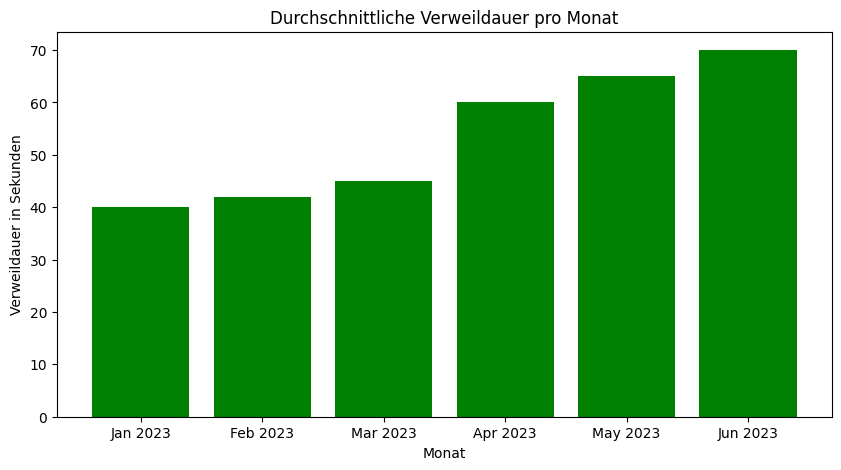


📈 Prognose der organischen Sitzungen


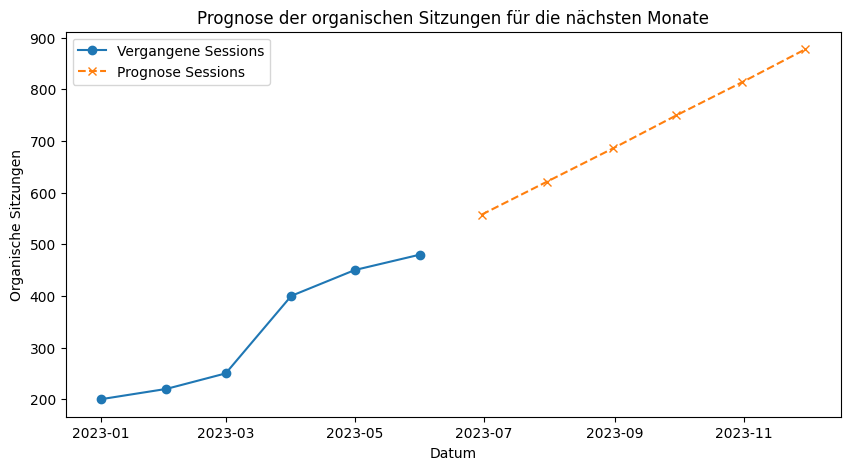


📈 Prognose der Conversion-Rate


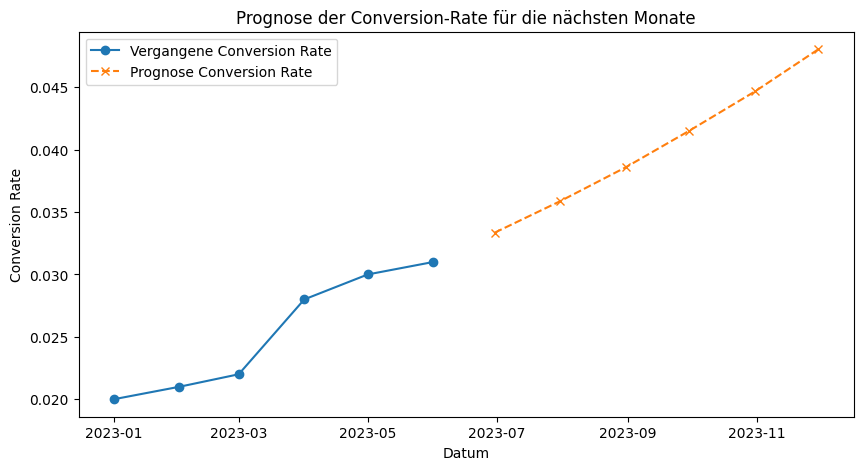

In [12]:
seo_analyzer = SEOAnalyzer(seo_json, original_texts, keywords_final, historical_data)
seo_analyzer.run_models()

# 🛏 embedding demo


📊 3D-Keyword Similarity


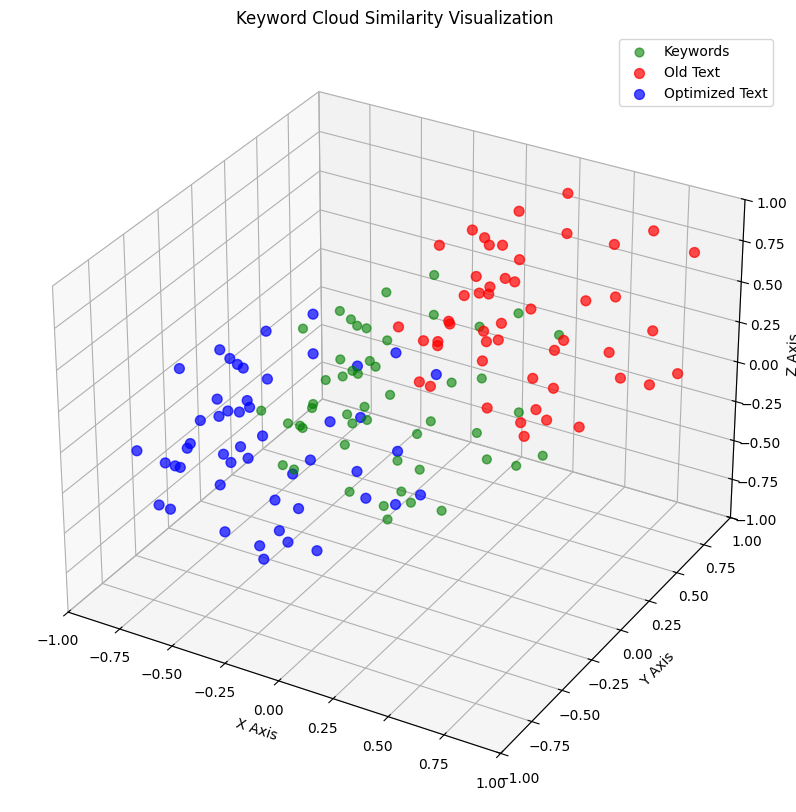


🔍 Cosine Similarity Steps


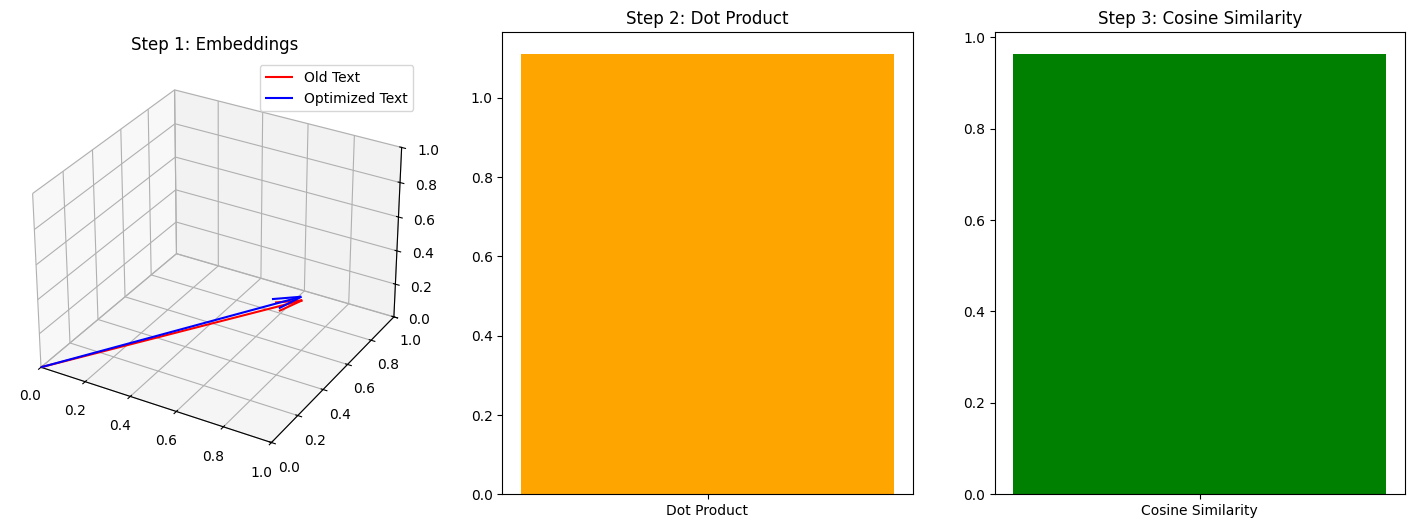


🔍 Cosine Comparision


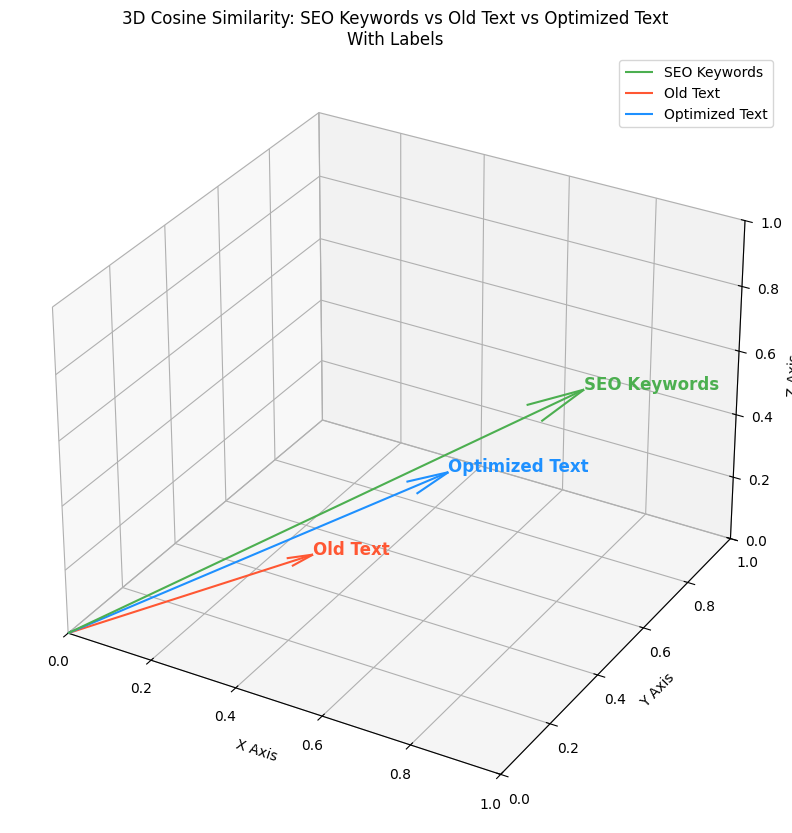


📌 3D BERT Embedding Visualization


In [13]:
import embeddingdemo
importlib.reload(embeddingdemo)
from embeddingdemo import EmbeddingDemo

demo = EmbeddingDemo()
demo.run_all_visualizations()

# ⛳ json to pdf + docx

In [14]:
%%capture
def json_to_html(json_data):
    # HTML-Template mit flexbox-basiertem Layout für "alt" und "SEO" nebeneinander
    html_template = """
    <!DOCTYPE html>
    <html lang="de">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Website Analyse</title>
        <style>
            body {
                font-family: Arial, sans-serif;
                margin: 20px;
                line-height: 1.6;
            }
            h1 {
                text-align: center;
                color: #333;
            }
            .section {
                margin-bottom: 20px;
            }
            .url {
                font-size: 1.2em;
                font-weight: bold;
                color: #007BFF;
                margin-bottom: 10px;
            }
            /* Flexbox für zwei Spalten nebeneinander */
            .compare-row {
                display: flex;
                flex-direction: row;
                gap: 20px; /* Abstand zwischen den Spalten */
                margin-bottom: 20px;
            }
            .column {
                flex: 1;
                border: 1px solid #ccc;
                padding: 10px;
                box-sizing: border-box;
            }
            .header {
                font-size: 1.1em;
                font-weight: bold;
                color: #555;
                margin-bottom: 10px;
            }
            .content {
                white-space: normal;
            }
            /* Um Zeilenumbrüche aus dem JSON in <br> umzuwandeln */
            .page-break {
                page-break-after: always;
            }
        </style>
    </head>
    <body>
        <h1>Website Analyse & SEO</h1>
        {% for url, sections in data.items() %}
        <div class="section">
            <!-- Website-URL -->
            <p class="url">Website: {{ url }}</p>

            <!-- Beispiel: Andere Felder wie Analyse und Erklärung einfach "normal" untereinander -->
            <p class="header">Analyse</p>
            <p class="content">{{ sections.Analyse | replace('\\n','<br>') | safe }}</p>

            <p class="header">Erklärung</p>
            <p class="content">{{ sections.Erklärung | replace('\\n','<br>') | safe }}</p>

            <!-- Jetzt die beiden Felder "alt" und "SEO" nebeneinander -->
            <div class="compare-row">
                <!-- linke Spalte: alt -->
                <div class="column">
                    <p class="header">alt</p>
                    <p class="content">{{ sections.alt | replace('\\n','<br>') | safe }}</p>
                </div>
                <!-- rechte Spalte: SEO -->
                <div class="column">
                    <p class="header">SEO</p>
                    <p class="content">{{ sections.SEO | replace('\\n','<br>') | safe }}</p>
                </div>
            </div>
        </div>
        <div class="page-break"></div>
        {% endfor %}
    </body>
    </html>
    """
    # Jinja2-Template Rendering
    template = Template(html_template)
    html_output = template.render(data=json_data)
    return html_output


html_output = json_to_html(seo_json)

# Speichere das HTML (Beispiel)
gdrive_seo_folder = userdata.get('gdrive_seo_folder')
with open("/content/drive/MyDrive/" + gdrive_seo_folder + "/output/preview.html", "w", encoding="utf-8") as file:
    file.write(html_output)


In [15]:
import json
from jinja2 import Template

def json_to_html(json_data):
    # HTML-Template mit EINER Spalte für "SEO" (die "alt"-Spalte entfällt)
    html_template = """
    <!DOCTYPE html>
    <html lang="de">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Website Analyse</title>
        <style>
            body {
                font-family: Arial, sans-serif;
                margin: 20px;
                line-height: 1.6;
            }
            h1 {
                text-align: center;
                color: #333;
            }
            .section {
                margin-bottom: 20px;
            }
            .url {
                font-size: 1.2em;
                font-weight: bold;
                color: #007BFF;
                margin-bottom: 10px;
            }
            .header {
                font-size: 1.1em;
                font-weight: bold;
                color: #555;
                margin-bottom: 10px;
            }
            .content {
                white-space: normal;
                margin-bottom: 20px;
            }
            .column {
                border: 1px solid #ccc;
                padding: 10px;
                box-sizing: border-box;
            }
            /* Zeilenumbrüche aus dem JSON in <br> wandeln */
            .page-break {
                page-break-after: always;
            }
        </style>
    </head>
    <body>
        <h1>Website Analyse & SEO</h1>

        {% for url, sections in data.items() %}
        <div class="section">
            <!-- Website-URL -->
            <p class="url">Website: {{ url }}</p>

            <!-- "Analyse" normal untereinander -->
            <p class="header">Analyse</p>
            <p class="content">
                {{ sections.Analyse | replace('\\n','<br>') | safe }}
            </p>

            <!-- "Erklärung" normal untereinander -->
            <p class="header">Erklärung</p>
            <p class="content">
                {{ sections.Erklärung | replace('\\n','<br>') | safe }}
            </p>

            <!-- NUR noch die "SEO"-Spalte -->
            <div class="column">
                <p class="header">SEO</p>
                <p class="content">
                    {{ sections.SEO | replace('\\n','<br>') | safe }}
                </p>
            </div>
        </div>
        <div class="page-break"></div>
        {% endfor %}
    </body>
    </html>
    """
    template = Template(html_template)
    return template.render(data=json_data)


html_output = json_to_html(seo_json)

# Speichere das HTML (Beispiel)
gdrive_seo_folder = userdata.get('gdrive_seo_folder')
with open("/content/drive/MyDrive/" + gdrive_seo_folder + "/output/preview.html", "w", encoding="utf-8") as file:
    file.write(html_output)


In [16]:
async def html_to_pdf_playwright(html_input, output_file):
    """
    Nutzt das Headless Chromium von Playwright, um die HTML-Datei zu rendern
    und anschließend als PDF zu speichern.
    """
    async with async_playwright() as p:
        browser = await p.chromium.launch()
        page = await browser.new_page()

        # Lokale Datei per file:// - Protokoll laden
        # oder du kannst stattdessen "page.set_content()" verwenden
        url = "file://" + html_input  # z.B. "file:///content/drive/MyDrive/.../preview.html"
        await page.goto(url, wait_until="load")

        # PDF erzeugen (A4, Ränder anpassen etc.)
        await page.pdf(
            path=output_file,
            format="A4",
            margin={"top": "1cm", "right": "1cm", "bottom": "1cm", "left": "1cm"}
        )

        await browser.close()

# Aufruf in Colab:
html_input = "/content/drive/MyDrive/" + gdrive_seo_folder + "/output/preview.html"
output_file = "/content/drive/MyDrive/" + gdrive_seo_folder + "/output/output.pdf"

# Instead of using asyncio.run(), use the following inside a notebook cell:
import nest_asyncio
nest_asyncio.apply() # This line applies a patch to allow nested event loops.
asyncio.run(html_to_pdf_playwright(html_input, output_file))
print("PDF mit Playwright erstellt.")

PDF mit Playwright erstellt.


In [17]:
input_file = "/content/drive/MyDrive/" + gdrive_seo_folder + "/output/preview.html"
output_file = "/content/drive/MyDrive/" + gdrive_seo_folder + "/output/output.docx"

pypandoc.convert_file(
    source_file=input_file,
    to="docx",
    outputfile=output_file,
    extra_args=["--standalone"]
)
print("Konvertierung nach DOCX abgeschlossen.")


Konvertierung nach DOCX abgeschlossen.


# 📥 RAG Sammlung Grammatikfehler

In [18]:
"Eine Zahnspange kann Kiefergelenksbeschwerden, Kauen- und Sprechprobleme effektiv behandeln."

"Als in Kenia geborene Kieferorthopädin bringt Dr. Graf eine multikulturelle Perspektive mit und spricht neben Deutsch auch Englisch, Swahili sowie über Grundkenntnisse in Arabisch und Anfängerkenntnisse in Spanisch."

"Die Hauptschwachstellen sind:"

"Sie hat ihren Master of Science in Kieferorthopädie von der Danube Private University, Krems, Österreich, und hat an der Heinrich-Heine-Universität Düsseldorf abgeschlossen."

"Ihre Qualifikationen umfassen nicht nur Fachwissen, sondern auch eine besondere Hingabe zu einem ästhetischen Lächeln. "

"behandlungsorientierte Zahnberatung"

"ästehthetisches Lächeln"

"Nachdem Ihr Behandlungsplan von der Krankenkasse genehmigt wurde" "Nachdem Ihr Behandlungsplan von der Krankenkasse bestätigt wurde"

"Der aktuelle Text zur Zahnspangenpraxis"

"Kieferorthopäde in [Ihre Stadt]"


'Kieferorthopäde in [Ihre Stadt]'

# 🎨 RAG

In [19]:
chatbot_system_prompt = (
    "Du bist ein hochqualifizierter Korrekturleser und optimierst Texte für SEO-Zwecke. "
    "Du bist Teil eines RAG Systems und deine Aufgabe ist es, grammatikalische Fehler zu erkennen. Du bist die finale Korrektur für die Texte."
    "Du wirst context retrieval zu den Texten erhalten. Du wirst die Texte nur korrigieren, wenn grammatikalische Fehler auftreten"
    " oder wenn es grobe Fehler in der Formulierung gibt. Denke daran, dass die Texte bereits otpimiert sind und nur die "
    "letzten Fehler erkannt werden müssen! Deswegen wirst du die Texte nur verändern, wenn du grammatikalische Fehler findest."
    "Wenn du Fehler findest, gebe den Text korrigiert zurück."
    "Wenn du keinen Fehler findest, gebe einfach nur den Text zurück."
    "Hier ist der context retrieval:"
)

chatbot_user_prompt = (
    "Bitte verbessere den folgenden Text:"
)

In [20]:
import rag
importlib.reload(rag)
from rag import RAG


# 1. RAG-Objekt anlegen
rag = RAG(FAISS_PATH, chatbot_system_prompt=chatbot_system_prompt,chatbot_user_prompt=chatbot_user_prompt)

# 2. Nur beim ersten Mal:
error_corrections = {
    "Eine Zahnspange kann Kiefergelenksbeschwerden, Kauen- und Sprechprobleme effektiv behandeln.":
    "Eine Zahnspange kann Kiefergelenksbeschwerden, sowie Kau- und Sprechprobleme effektiv behandeln.",
    "Als in Kenia geborene Kieferorthopädin bringt Dr. Meier eine multikulturelle Perspektive mit und spricht neben Deutsch auch Englisch, Swahili sowie über Grundkenntnisse in Arabisch und Anfängerkenntnisse in Spanisch.":
    "Als in Kenia geborene Kieferorthopädin bringt Dr. Meier eine multikulturelle Perspektive mit und spricht neben Deutsch auch Englisch und Swahili. Dazu hat sie Grundkenntnisse in Arabisch und Anfängerkenntnisse in Spanisch.",
    "Sie hat ihren Master of Science in Kieferorthopädie von der Danube Private University, Krems, Österreich, und hat an der Heinrich-Heine-Universität Düsseldorf abgeschlossen.":
    "Sie hat ihren Master of Science in Kieferorthopädie von der Danube Private University, Krems, Österreich, und hat an der Heinrich-Heine-Universität Düsseldorf promoviert.",
    "Ihre Qualifikationen umfassen nicht nur Fachwissen, sondern auch eine besondere Hingabe zu einem ästhetischen Lächeln.":
    "Sie ist hoch qualifiziert und hat eine besondere Hingabe zu einem ästhetischen Lächeln. ",
    "behandlungsorientierte Zahnberatung": "patientenorientierte Beratung",
    "ästehthetisches Lächeln": "ästhetisches Lächeln",
    "Nachdem Ihr Behandlungsplan von der Krankenkasse genehmigt wurde": "Nachdem Ihr Behandlungsplan von der Krankenkasse bestätigt wurde",
    "Der aktuelle Text zur Zahnspangenpraxis": "Der aktuelle Text zur kieferorthopädischen Praxis"
}
rag.initialize_db(error_corrections=error_corrections)

# 3. Weitere Einträge
# new_entries = {
#     "Unsere Firma hat viele zufriedene Kunde": "Unsere Firma hat viele zufriedene Kunden"
# }
# rag.add_entries(new_entries)

# 4. Text prüfen
seo_text = seo_json['https://www.rue-zahnspange.de/']['SEO']
improved = rag.check_text(seo_text)
print("Verbesserter Text:\n", improved)


✅ Ein vorhandener FAISS-Index wurde gefunden. Lade Index...
🔎 Lade vorhandenen FAISS-Index...
✅ Index und Fehler-Korrekturen aus '/content/drive/MyDrive/Colab Notebooks/SEO/data/faiss_db' geladen.
Moderne Zahnspangen in Essen-Rüttenscheid für ein gesünderes Lächeln 

Entdecken Sie die Praxis RÜ Zahnspange in Essen-Rüttenscheid und unsere vielseitigen Behandlungen für Kinder und Jugendliche, die ein langanhaltendes und gesundes Lächeln ermöglichen. 

Öffnungszeiten 

Hier finden Sie uns 

Anbindungen: Vor unserer Tür befindet sich die Haltestelle Martinstraße, erreichbar über: 
Bahn: 107, 108, U11 
Bus: 142, 160, 161 

Direkt gegenüber der Praxis befindet sich ein geräumiger Parkplatz. 

Behandlungen für ein perfektes Lächeln 

Unser Ziel ist es, Ihnen nicht nur ein ästhetisch ansprechendes Lächeln zu schenken, sondern auch Ihre gesamte Kiefergesundheit zu verbessern. Wir begleiten Sie auf jedem Schritt dieses Weges mit Professionalität und Sorgfalt. 

Transparente Aufklärung 

Wir setz

In [21]:
import os
import json
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer
from chatbot import Chatbot

# -------------------------
# 1) VectorDB
# -------------------------

class VectorDB:
    """
    Eine Klasse für alles rund um deine Vektordatenbank:
    - Aufbauen & Laden (FAISS)
    - Neue Einträge hinzufügen
    - Querying für Context Retrieval
    """

    def __init__(self, db_folder):
        """
        :param db_folder: Pfad zu deinem Datenbank-Ordner, z.B. "/content/drive/MyDrive/SEO/data"
        """
        self.db_folder = db_folder
        self.index_file = os.path.join(db_folder, "faiss_index.bin")
        self.json_file  = os.path.join(db_folder, "faiss_index.json")

        self.index = None
        self.error_dict = {}  # z.B. {fehler: korrektur}

        self.model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

    def build_index(self, error_corrections: dict):
        """
        Baut einen neuen FAISS-Index aus den übergebenen Fehler-Korrektur-Paaren.
        """
        print("🔨 Baue neuen FAISS-Index...")
        os.makedirs(self.db_folder, exist_ok=True)

        self.error_dict = error_corrections
        errors = list(self.error_dict.keys())

        # Embeddings
        embeddings = np.array([self.model.encode(e) for e in errors], dtype="float32")

        # FAISS-Index anlegen
        self.index = faiss.IndexFlatL2(embeddings.shape[1])
        self.index.add(embeddings)

        # Daten auf Festplatte schreiben
        faiss.write_index(self.index, self.index_file)
        with open(self.json_file, "w", encoding="utf-8") as f:
            json.dump(self.error_dict, f, ensure_ascii=False)

        print(f"✅ Neuer Index + JSON in '{self.db_folder}' erstellt.")

    def load_index(self):
        """
        Lädt einen bereits existierenden FAISS-Index und die Fehler-Daten.
        """
        if not (os.path.exists(self.index_file) and os.path.exists(self.json_file)):
            raise FileNotFoundError("❌ Kein FAISS-Index gefunden. Bitte build_index() aufrufen.")

        print("🔎 Lade vorhandenen FAISS-Index...")
        self.index = faiss.read_index(self.index_file)

        with open(self.json_file, "r", encoding="utf-8") as f:
            self.error_dict = json.load(f)

        print("✅ Index & Fehler-Korrekturen geladen.")

    def add_entries(self, new_error_corrections: dict):
        """
        Fügt weitere Fehler-Korrektur-Paare hinzu, ohne alles neu zu bauen.
        """
        if self.index is None:
            # Versuch zu laden, falls vorhanden
            if os.path.exists(self.index_file) and os.path.exists(self.json_file):
                self.load_index()
            else:
                raise FileNotFoundError("❌ Kein Index vorhanden. Bitte erst build_index() nutzen.")

        # Merge in self.error_dict
        for fehler, korrektur in new_error_corrections.items():
            self.error_dict[fehler] = korrektur

        # embeddings nur für die neuen keys
        new_keys = list(new_error_corrections.keys())
        new_embeds = np.array([self.model.encode(k) for k in new_keys], dtype="float32")

        # An Index anhängen
        self.index.add(new_embeds)

        # Speichern
        faiss.write_index(self.index, self.index_file)
        with open(self.json_file, "w", encoding="utf-8") as f:
            json.dump(self.error_dict, f, ensure_ascii=False)

        print(f"✅ {len(new_keys)} neue Einträge hinzugefügt und Index aktualisiert.")

    def query(self, text: str, top_k=3, threshold=0.6):
        """
        Sucht in der DB nach ähnlichen fehlerhaften Formulierungen.

        :param text: Der zu prüfende Satz/Abschnitt
        :param top_k: Anzahl der gesuchten Ähnlichkeiten
        :param threshold: Distanzschwelle
        :return: Liste [(fehler, korrektur), ...]
        """
        if self.index is None:
            self.load_index()

        embed = np.array([self.model.encode(text)], dtype="float32")
        distances, indices = self.index.search(embed, top_k)

        all_errors = list(self.error_dict.keys())

        results = []
        for i in range(top_k):
            if distances[0][i] < threshold:
                fehler_key = all_errors[indices[0][i]]
                korrektur = self.error_dict[fehler_key]
                results.append((fehler_key, korrektur))
        return results

    def retrieve_context(self, seo_text: str) -> str:
        """
        Durchsucht den seo_text Satz für Satz, holt ggf. Korrekturvorschläge
        und baut einen Kontextstring.
        """
        lines = []
        for s in seo_text.split(". "):
            suggestions = self.query(s)
            for old, new in suggestions:
                lines.append(f"- Fehler: {old} ➝ Verbesserung: {new}")

        if lines:
            return "Bekannte Fehler/Korrekturen:\n" + "\n".join(lines)
        else:
            return "Keine bekannten Fehler gefunden."



In [22]:
import os
import json
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer
from chatbot import Chatbot
# -------------------------
# 2) PromptManager
# -------------------------

class PromptManager:
    """
    Lädt Prompts aus dem /data/prompts Ordner und kombiniert sie mit
    dem Context aus der VectorDB, um einen finalen Prompt zu erstellen.
    """

    def __init__(self, prompts_folder="./data/prompts"):
        """
        :param prompts_folder: Ordner, in dem .json (oder .txt) Prompts liegen
        """
        self.prompts_folder = prompts_folder
        # Du könntest hier diverse Prompts laden oder
        # sie dynamisch in build_final_prompt() nach Dateiname laden

    def load_prompt(self, filename: str) -> dict:
        """
        Lädt einen JSON-Prompt aus dem Ordner, z.B. 'grammar_prompt.json'.
        """
        path = os.path.join(self.prompts_folder, filename)
        try:
            with open(path, "r", encoding="utf-8") as f:
                return json.load(f)
        except FileNotFoundError:
            print(f"⚠️ Prompt-Datei {path} nicht gefunden!")
            return {}
        except json.JSONDecodeError:
            print(f"⚠️ Ungültiges JSON in {path}")
            return {}

    def build_final_prompt(self, base_prompt_file: str, context: str, user_text: str) -> (str, str):
        """
        Kombiniert:
         - base_prompt_file (System-/User-Prompts)
         - den 'context' aus der VectorDB
         - den 'user_text' (SEO-Text)
        und gibt final (system_prompt, user_prompt) zurück.
        """
        prompt_data = self.load_prompt(base_prompt_file)

        # Annahme: JSON enthält z.B. { "system_prompt": "...", "user_prompt": "..." }
        system_prompt = prompt_data.get("system_prompt", "")
        user_prompt   = prompt_data.get("user_prompt", "")

        # Kontext an system_prompt anhängen
        system_prompt_full = f"{system_prompt}\n{context}"

        # SEO-Text an user_prompt anhängen
        user_prompt_full = f"{user_prompt}\n\n{user_text}"

        return (system_prompt_full, user_prompt_full)




In [23]:
import os
import json
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer
from chatbot import Chatbot
# -------------------------
# 3) SEOGrammarChecker
# -------------------------

class SEOGrammarChecker:
    """
    Nutzt VectorDB, um Kontext zu holen,
    PromptManager, um finalen Prompt zu bauen,
    und Chatbot, um den Text zu optimieren.
    """

    def __init__(self, vector_db: VectorDB, prompt_manager: PromptManager):
        """
        :param vector_db: Instanz von VectorDB
        :param prompt_manager: Instanz von PromptManager
        """
        self.vector_db = vector_db
        self.prompt_manager = prompt_manager

    def check_text(self, seo_text: str, prompt_file: str = "grammar_prompt.json") -> str:
        """
        1) Hole Context aus VectorDB
        2) Lade base_prompt aus 'prompt_file'
        3) Baue finalen Prompt
        4) Chatbot-Aufruf
        :return: Grammatikalisch verbesserter Text
        """
        # 1) Kontext für den Text
        context_str = self.vector_db.retrieve_context(seo_text)

        # 2) Prompts aus JSON
        # z.B. { "system_prompt": "Du bist ein Korrektor...", "user_prompt": "Bitte verbessere..." }
        (system_prompt, user_prompt) = self.prompt_manager.build_final_prompt(
            base_prompt_file=prompt_file,
            context=context_str,
            user_text=seo_text
        )

        # 3) Chatbot-Aufruf
        cb = Chatbot(systemprompt=system_prompt, userprompt=user_prompt)
        final_text = cb.chat()
        return final_text


# ⛓ Langchain

In [24]:
!pip install --upgrade pydantic

  Using cached pydantic-2.10.6-py3-none-any.whl.metadata (30 kB)
Using cached pydantic-2.10.6-py3-none-any.whl (431 kB)
  Attempting uninstall: pydantic
    Found existing installation: pydantic 1.10.21
    Uninstalling pydantic-1.10.21:
      Successfully uninstalled pydantic-1.10.21
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spacy 3.5.0 requires pydantic!=1.8,!=1.8.1,<1.11.0,>=1.7.4, but you have pydantic 2.10.6 which is incompatible.
en-core-web-sm 3.7.1 requires spacy<3.8.0,>=3.7.2, but you have spacy 3.5.0 which is incompatible.


In [57]:
import subprocess
from langchain_openai import ChatOpenAI
from google.colab import userdata
import os

subprocess.run(["pip", "install", "--upgrade", "pydantic"])

os.environ['OPENAI_API_KEY'] = userdata.get('open_ai_api_key')

llm = ChatOpenAI(temperature=0,
    model = "gpt-4o-mini-2024-07-18",
    openai_api_key=os.environ['OPENAI_API_KEY'],
)

In [73]:
from typing_extensions import assert_type
from utils import load_prompts

prompts = load_prompts(PROMPT_PATH + '/optimize_seo.json')


system_prompt = prompts["system_prompt"]
user_prompt = prompts["user_prompt"]


user_prompt = user_prompt.replace('{keywords}', google_ads_keywords.__str__())
user_prompt = user_prompt.replace('{original_text}', unternehmens_text)

print(user_prompt)

Optimiere den folgenden Text für SEO, indem du die Keywords sinnvoll integrierst:

Keywords: ['zahnärzte essen rüttenscheid', 'zahn spange', 'zahnzusatzversicherung bei kindern', 'retainer kosten', 'retainer zähne', 'kfo essen', 'zahnspangen englisch', 'reinigung zahnschienen', 'zahnschienen reinigung', 'kieferorthopädische zahnzusatzversicherung', 'invisalign erfahrung', 'kiefer fehlstellung', 'zahn retainer', 'gerade zahne']

Text:

    Unser Unternehmen bietet hochwertige Gartengeräte in München. Von Rasenmähern bis Heckenscheren, wir beraten persönlich.
    

Achte auf natürliche Sprache, gute Lesbarkeit und Vermeide Keyword-Stuffing.
Gib den optimierten Text zurück.


In [59]:
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.schema import (AIMessage, HumanMessage, SystemMessage)

def extract_keywords(text):
    prompt = ChatPromptTemplate.from_messages([
        SystemMessage(content="Du bist ein SEO-Experte, spezialisiert auf Keyword-Recherche."),
        HumanMessage(content=f"""
        Analysiere den folgenden Unternehmens-Text und finde die besten SEO-Keywords.
        Berücksichtige lokale Infos, falls vorhanden.

        Text:
        {text}

        Gib mir eine Liste von Keywords.
        """)
    ])
    # format_messages converts the messages to a list of dictionaries
    messages = prompt.format_messages(text=text)
    response = llm(messages)
    return response.content

In [60]:
def optimize_text_for_seo(text, keywords):
    prompt = ChatPromptTemplate.from_messages([
        SystemMessage(content="Du bist ein professioneller SEO-Texter."),
        HumanMessage(content=f"""
        Optimiere den folgenden Text für SEO, indem du diese Keywords sinnvoll integrierst:

        Keywords: {keywords}

        Achte auf natürliche Sprache, gute Lesbarkeit und Vermeidung von Keyword-Stuffing.

        Text:
        {text}

        Gib mir den optimierten Text zurück.
        """)
    ])
    # format_messages converts the messages to a list of dictionaries
    messages = prompt.format_messages(text=text, keywords=keywords)  # Pass keywords here
    response = llm(messages)
    return response.content


In [61]:
def grammar_and_style_check(text):
    prompt = ChatPromptTemplate.from_messages([
        SystemMessage(content="Du bist ein erfahrener Lektor und Sprachexperte."),
        HumanMessage(content=f"""
        Prüfe den folgenden Text auf Grammatik, Rechtschreibung und Stil.
        Mache den Text flüssig, professionell und fehlerfrei.

        Text:
        {text}

        Gib den verbesserten Text zurück.
        """)
    ])
    # format_messages converts the messages to a list of dictionaries
    messages = prompt.format_messages(text=text)  # Format with text
    response = llm(messages)
    return response.content

In [62]:
def supervisor_check(original_text, keywords, optimized_text, final_text):
    prompt = ChatPromptTemplate.from_messages([
        SystemMessage(content="Du bist ein Supervisor, der SEO- und Textqualität überprüft."),
        HumanMessage(content=f"""
        Hier sind die Arbeitsschritte:

        Ursprünglicher Text:
        {original_text}

        Gefundene Keywords:
        {keywords}

        SEO-optimierter Text:
        {optimized_text}

        Finaler Text (nach Lektorat):
        {final_text}

        Beantworte:
        1. Sind alle wichtigen Keywords sinnvoll eingebaut?
        2. Ist der Text professionell und lesbar?
        3. Verbesserungsvorschläge?
        Wenn alles gut ist, antworte: 'Finaler Text akzeptiert.'
        """)
    ])
    # format_messages converts the messages to a list of dictionaries
    messages = prompt.format_messages(
        original_text=original_text,
        keywords=keywords,
        optimized_text=optimized_text,
        final_text=final_text
    )  # Format with all variables
    response = llm(messages)
    return response.content

In [63]:
def seo_pipeline(original_text):
    # Schritt 1: Keywords finden
    print("Schritt 1: Keywords finden...")
    keywords = extract_keywords(original_text)
    print("Gefundene Keywords:", keywords)

    # Schritt 2: SEO-Optimierung
    print("\nSchritt 2: SEO-Optimierung...")
    optimized_text = optimize_text_for_seo(original_text, keywords)
    print("SEO-optimierter Text:\n", optimized_text)

    # Schritt 3: Grammatikprüfung
    print("\nSchritt 3: Grammatikprüfung...")
    final_text = grammar_and_style_check(optimized_text)
    print("Finaler Text nach Lektorat:\n", final_text)

    # Optional: Supervisor
    print("\nSupervisor prüft...")
    supervisor_feedback = supervisor_check(original_text, keywords, optimized_text, final_text)
    print("Supervisor Feedback:\n", supervisor_feedback)

    return final_text


In [64]:
if __name__ == "__main__":
    unternehmens_text = """
    Unser Unternehmen bietet hochwertige Gartengeräte in München. Von Rasenmähern bis Heckenscheren, wir beraten persönlich.
    """

    final_output = seo_pipeline(unternehmens_text)
    print("\n--- Finaler SEO-optimierter Text ---\n")
    print(final_output)


Schritt 1: Keywords finden...
Gefundene Keywords: Hier ist eine Liste von potenziellen SEO-Keywords, die auf dem bereitgestellten Unternehmens-Text basieren:

1. Gartengeräte München
2. hochwertige Gartengeräte München
3. Rasenmäher kaufen München
4. Heckenscheren München
5. Gartengeräte Beratung München
6. Gartenwerkzeuge München
7. Rasenmäher Beratung München
8. Heckenschneider München
9. Gartengeräte Fachgeschäft München
10. Gartenpflege München
11. Gartengeräte Verkauf München
12. Gartenbedarf München
13. professionelle Gartengeräte München
14. Gartengeräte für den Heimgebrauch München
15. lokale Gartengeräte München

Diese Keywords sind sowohl lokal als auch thematisch relevant und können helfen, die Sichtbarkeit des Unternehmens in Suchmaschinen zu erhöhen.

Schritt 2: SEO-Optimierung...
SEO-optimierter Text:
 Entdecken Sie unser Fachgeschäft für hochwertige Gartengeräte in München! Wir bieten eine umfangreiche Auswahl an Gartenwerkzeugen, darunter Rasenmäher, Heckenschneider und

In [32]:
google_ads_keywords=['zahnärzte essen rüttenscheid',
 'zahn spange',
 'zahnzusatzversicherung bei kindern',
 'retainer kosten',
 'retainer zähne',
 'kfo essen',
 'zahnspangen englisch',
 'reinigung zahnschienen',
 'zahnschienen reinigung',
 'kieferorthopädische zahnzusatzversicherung',
 'invisalign erfahrung',
 'kiefer fehlstellung',
 'zahn retainer',
 'gerade zahne']

In [38]:
DATA_PATH + '/prompts'

'/content/drive/MyDrive/Colab Notebooks/SEO/data/prompts'

In [56]:
import seo_pipeline
importlib.reload(seo_pipeline)
from seo_pipeline import LangchainSEOPipeline

pipeline = LangchainSEOPipeline(
    prompts_folder=DATA_PATH + '/prompts',
    google_ads_keywords=google_ads_keywords
)

final_result = pipeline.run_pipeline( """
Unser Unternehmen bietet hochwertige Gartengeräte in München.
Von Rasenmähern bis Heckenscheren, wir beraten persönlich und regional.
""")

=== Langchain SEO Pipeline ===
-> Nutze vorhandene Google Ads Keywords, überspringe LLM-Keyword-Extraktion.
Gefundene/Genutzte Keywords: zahnärzte essen rüttenscheid, zahn spange, zahnzusatzversicherung bei kindern, retainer kosten, retainer zähne, kfo essen, zahnspangen englisch, reinigung zahnschienen, zahnschienen reinigung, kieferorthopädische zahnzusatzversicherung, invisalign erfahrung, kiefer fehlstellung, zahn retainer, gerade zahne

SEO-Optimierter Text:
 Gerne helfe ich dir dabei, deinen Text für SEO zu optimieren. Bitte teile mir die Keywords und den Originaltext mit, damit ich die Anpassungen vornehmen kann.

Finaler Text nach Lektorat:
 Gerne! Bitte füge den Text ein, den du überprüft und verbessert haben möchtest.

Supervisor Feedback:
 Bitte geben Sie den ursprünglichen Text, die gefundenen Keywords, den SEO-optimierten Text und den finalen Text an, damit ich die gewünschten Überprüfungen durchführen kann.


In [42]:
[seo_json['https://www.rue-zahnspange.de/']['SEO']]

['Moderne Zahnspangen in Essen-Rüttenscheid für ein gesünderes Lächeln Entdecken Sie die Praxis RÜ Zahnspange in Essen-Rüttenscheid und unsere vielseitigen Behandlungen für Kinder und Jugendliche, die ein langanhaltendes und gesundes Lächeln ermöglichen. Öffnungszeiten Hier finden Sie uns Anbindungen Vor unserer Tür befindet sich die Haltestelle Martinstraße, erreichbar über: Bahn: 107, 108, U11 Bus: 142, 160, 161 Direkt gegenüber der Praxis befindet sich ein geräumiger Parkplatz. Behandlungen für ein perfektes Lächeln Unser Ziel ist es, Ihnen nicht nur ein ästhetisch ansprechendes Lächeln zu schenken, sondern auch Ihre gesamte Kiefergesundheit zu verbessern. Wir begleiten Sie auf jedem Schritt dieses Weges mit Professionalität und Sorgfalt. Transparente Aufklärung Wir setzen auf offene Kommunikation und ausführliche Beratung, damit Sie jeden Schritt Ihrer kieferorthopädischen Behandlung klar verstehen. Spezialisiert auf Kinder und Jugendliche in Essen-Rüttenscheid Unser kinderfreundli

In [46]:
prompt_template = self.load_prompt("optimize_seo.json")

messages = prompt_template.format_messages(
    original_text="TESTTESTTEST",
    keywords="kaufen, münchen"
)

for msg in messages:
    print(msg.role, "->", msg.content)

# Falls du hier "SystemMessage -> Du bist ein professioneller SEO-Texter."
# und "HumanMessage -> Optimiere den folgenden Text:
# TESTTESTTEST
#
# Nutze diese Keywords:
# kaufen, münchen
# ..."  siehst, dann stimmt das Mapping.


NameError: name 'self' is not defined